# Profiling in Python

There are several different ways to measure resource usage in Python applications, which help identify where an application should be parallelized and what kinds of design patterns from Ray core to use.
to show how to determine where to parallelize.
We'll introduce profiling methods to measure memory allocation, objects creation, deterministic profiling (call stack), sampling, etc., plus different means of visualization.

The following example uses a Monte Carlo method for approximating the value of π, based on the tutorial ["Ray Crash Course - Tasks"](https://github.com/anyscale/academy/blob/main/ray-crash-course/01-Ray-Tasks.ipynb) by Dean Wampler.

We'll compare/contrast the serial implementation versus use of remote tasks to help parallelize this application.
Then we'll analysze the per-CPU speedup, and also consider the overhead costs of using Ray core features -- to understand more about the trade-offs being made.

In [1]:
%load_ext watermark
%watermark -v -m

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.21.0

Compiler    : Clang 6.0 (clang-600.0.57)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



## Launch Ray

First, start Ray and open its dashboard in another browser tab:

In [2]:
import logging
import ray

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)

print(f"Dashboard URL: http://{ray.get_dashboard_url()}")

Dashboard URL: http://127.0.0.1:8265


## Application Code

Define a simple function that uses a stochastic method of approximating π, repeated through some number of samples:

In [3]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import time

def estimate_pi (num_samples):
    xs = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the x coordinate
    ys = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the y coordinate
    xys = np.stack((xs, ys), axis=-1)                              # similar to Python's "zip(a,b)"; creates np.array([(x1,y1), (x2,y2), ...]).

    inside = (xs**2.0 + ys**2.0) <= 1.0                            # create a predicate over all the array elements
    xys_inside = xys[inside]                                       # select only those  elements inside the circle
    in_circle = xys_inside.shape[0]                                # return the number of elements inside the circle
    approx_pi = 4.0 * in_circle / num_samples                      # the Pi estimate

    return approx_pi

Since this approximation requires many samples, which are independent, a *task-parallel* pattern can be applied. We'll create a *remote task* version of the sampling function:

In [4]:
@ray.remote
def distrib_estimate_pi (num_samples):
    return estimate_pi(num_samples)

Another function will collect measures for one epoch, i.e., some number of trials:

In [5]:
def run_epoch (num_samples, num_trials, distrib=False):
    start = time.time()
    
    if distrib:
        refs = [distrib_estimate_pi.remote(num_samples) for _ in range(num_trials)]
        pis = ray.get(refs)
    else:
        pis = [estimate_pi(num_samples) for _ in range(num_trials)]

    # measure CPU time for the code section parallelized as a remote task
    duration = time.time() - start

    approx_pi = statistics.mean(pis)
    stdev = statistics.stdev(pis)
    error = 100.0 * abs(approx_pi - np.pi) / np.pi

    return num_samples, duration, approx_pi, stdev, error

Define class to manage the simulation:

In [6]:
class Sim:
    DF_COL_NAMES = ["n", "duration", "approx_pi", "stdev", "error"]
    NUM_SAMPLES = 1000000
    NUM_TRIALS = 20
    STEP_SIZE = int(NUM_SAMPLES / 25)

    def __init__ (self, distrib=False, num_samples=NUM_SAMPLES, num_trials=NUM_TRIALS, step_size=STEP_SIZE):
        self.distrib = distrib
        self.num_samples = num_samples
        self.num_trials = num_trials
        self.step_size = step_size
        self.df = None


    def run (self):
        # use a minimum of 2 trials, to be able to calculate standard deviation
        results = [
            run_epoch(n_samp, self.num_trials, distrib=self.distrib)
            for n_samp in range(2, self.num_samples, self.step_size)
        ]
    
        self.df = pd.DataFrame(results, columns=self.DF_COL_NAMES)
        return self


    def plot (self):
        plt.plot("n", "duration", data=self.df, color="green", linewidth=1, linestyle="dashed")
        plt.plot("n", "error", data=self.df, color="red", linewidth=0.5, linestyle="dashed")
        plt.plot("n", "stdev", data=self.df, color="blue", linewidth=2)

        plt.yscale("log")
        plt.legend()
        plt.show()
        return self

## Profiling Tools

Next, we'll set up to use the following tools for profiling in Python:

  * [`objgraph`](https://mg.pov.lt/objgraph/)
  * [`tracemalloc`](https://docs.python.org/3/library/tracemalloc.html)
  * [`prun`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun)
  * [`snakeviz`](https://jiffyclub.github.io/snakeviz/)
  * [`pyinstrument`](https://github.com/joerick/pyinstrument/)

In [7]:
import objgraph
import tracemalloc
import pyinstrument

%load_ext snakeviz

### Object Creation

The first method of profiling shown here uses
[`objgraph`](https://mg.pov.lt/objgraph/)
to examine a before/after contrast of what objects are getting generated by the application.
While other profiling methods can be repeated, this kind of analysis requires some special handling (isolation) and should be run first -- before other tools make the runtime environment confusing to analyze.
The objectives here are to understand:

  1. Which kinds of objects are growing (by count)
  2. How the different objects refer to each other

That can help identify if there are problems with allocating many objects, which might require the application code to be reworked.

First we'll measure a baseline of the top 10 kinds of objects that have been created so far:

In [8]:
objgraph.show_growth(limit=10)

function              32784    +32784
dict                  19327    +19327
tuple                 15217    +15217
list                   7502     +7502
weakref                5612     +5612
cell                   5370     +5370
getset_descriptor      4345     +4345
type                   3488     +3488
method_descriptor      3299     +3299
wrapper_descriptor     3188     +3188


Then run the simulation serially **once**:

In [9]:
%%time

sim_s = Sim(distrib=False, num_samples=Sim.NUM_SAMPLES)
sim_s.run();

CPU times: user 9.85 s, sys: 2.2 s, total: 12.1 s
Wall time: 12.2 s


Now we can measure the object counts again, and examine the growth (by contrast):

In [10]:
objgraph.show_growth()

dict                          19345       +18
weakref                        5619        +7
builtin_function_or_method     2952        +6
SignalDict                       28        +4
Future                           10        +4
list                           7505        +3
cell                           5373        +3
set                             952        +3
generator                        12        +3
Runner                            5        +3


In [11]:
objgraph.show_most_common_types() 

function           32777
dict               19351
tuple              15227
list               7508
weakref            5619
cell               5377
getset_descriptor  4345
type               3488
method_descriptor  3299
wrapper_descriptor 3188


The top few categories are function calls, dictionaries, and tuples – which is expected, given how our π approximations create lots of NumPy arrays.
As expected, there's nothing much there to worry about – although in applications which large memory use we might need to parallelize so that each unit of work had more available memory.

Next, let's examine a graph of how object make reference to other objects.
This can be useful for tracing potential memory leaks...

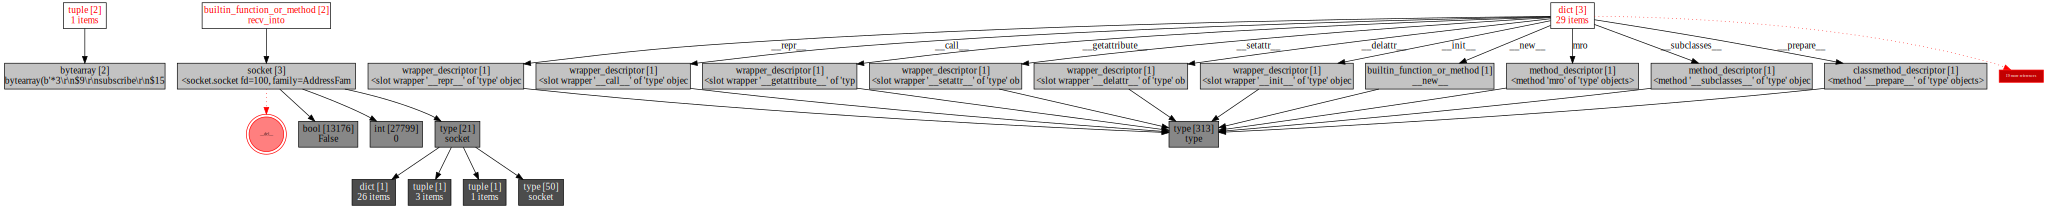

In [12]:
roots = objgraph.get_leaking_objects()
objgraph.show_refs(roots[:3], refcounts=True)

### Memory Allocation

The next profiling method uses
[`tracemalloc`](https://docs.python.org/3/library/tracemalloc.html)
to trace the memory blocks allocated by Python.
Thi provides the following information:

  * traceback to where an object got allocated
  * statistics about allocated memory blocks per filename, per line: total size, number and average size
  * computing the differences between two snapshots to detect memory leaks
  
We'll run the application serially to capture a snapshot:

In [13]:
tracemalloc.start()

Sim(distrib=False, num_samples=Sim.NUM_SAMPLES).run()

snapshot = tracemalloc.take_snapshot()

In [14]:
top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
for stat in top_stats:
    print("%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))

    for line in stat.traceback.format():
        print(line)

8 memory blocks: 4.3 KiB
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/redis/connection.py", line 417
    raise_on_timeout=False)
26 memory blocks: 2.3 KiB
  File "<__array_function__ internals>", line 6
2 memory blocks: 1.1 KiB
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 552
    signaled = self._cond.wait(timeout)
40 memory blocks: 0.9 KiB
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/statistics.py", line 535
    T, total, count = _sum((x-c)**2 for x in data)
1 memory blocks: 0.8 KiB
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1880
    stacked = np.empty(shape, dtype=dtype)
2 memory blocks: 0.7 KiB
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 361
    new_data, dtype=new_dtype, copy=False, name=name, **kwargs
24 memor

There should not be any *memory leaks* in this application.

### Deterministic Profiling

The
[`%%prun` magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun)
invokes the
[cProfile](https://docs.python.org/3/library/profile.html)
*deterministic* profiler in Python to trace how often and for what duration the different functions get called.
In other words, we'll track of the call stack statistics to understand more about CPU use.
This configures the profiler to save data to the file `prof_cpu.txt` as text.

The [`%%snakeviz` magic](https://jiffyclub.github.io/snakeviz/)
then analyzes that profiling data and generates an interactive report.

Note that *deterministic profiling* creates some overhead which can distort the measurements in relatively small code blocks or short-running code, although it's generally find for long-running programs.

In [15]:
%%prun -q -T prof_cpu.txt
%%snakeviz

Sim(distrib=False, num_samples=Sim.NUM_SAMPLES).run()

 
*** Profile stats marshalled to file '/var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/tmpetbfumkp'. 
Embedding SnakeViz in this document...


 
*** Profile printout saved to text file 'prof_cpu.txt'. 


The *icicle* interactive chart illustrates how so very much of the overall CPU cost is in the `estimate_pi()` method.

### Sampling Profiler

The
[`pyinstrument`](https://github.com/joerick/pyinstrument/)
library provides a *sampling profiler* – an alternative way to measure the call stack and CPU use.
While not *exact*, this approach creates less overhead:


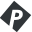

In [16]:
profiler = pyinstrument.Profiler()
profiler.start()

Sim(distrib=False, num_samples=Sim.NUM_SAMPLES).run()

profiler.stop()
display(HTML(profiler.output_html()))

Again, the `estimate_pi()` function is where most of the CPU cost occurs, although we can get clearer measures for how much overhead there is among the rest of code.
In this case the cumulative overhead is relatively small, probably measured in milliseconds.

## Results of Serial Execution

Now let's look at a visualization of the *number of samples* plotted versus *duration*, *error*, and *standard deviation*:

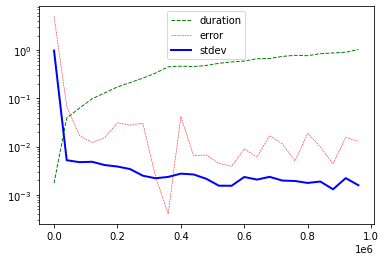

In [17]:
sim_s.plot();

Note how the *standard deviation* drops quickly.
We can calculate that measure without even knowing an "exact" value of π (the *error* measure), so we could potentially rework this application to have an *early termination* by setting a threshold on the *stdev* measure.

In [18]:
sim_s.df.describe()

,n,duration,approx_pi,stdev,error
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,480002.000000,0.485793,3.147822,0.041689,0.216872
std,294392.028878,0.303427,0.031711,0.195218,1.005402
min,2.000000,0.001745,3.139438,0.001307,0.000403
25%,240002.000000,0.212424,3.141282,0.001940,0.006117
50%,480002.000000,0.480969,3.141454,0.002350,0.012149
75%,720002.000000,0.741167,3.142076,0.003425,0.018907
max,960002.000000,1.030250,3.300000,0.978721,5.042262


## Results of Parallel Execution

Now let's run again and this time parallelize the application using *remote tasks*, by setting the `distrib=True` flag.
We'll use the `%%time` magic to show the "wall clock" CPU time:

In [19]:
%%time

sim_d = Sim(distrib=True, num_samples=Sim.NUM_SAMPLES)
sim_d.run();

CPU times: user 476 ms, sys: 111 ms, total: 587 ms
Wall time: 7.41 s


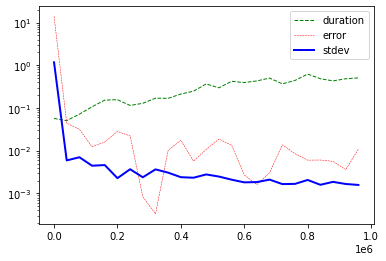

In [20]:
sim_d.plot();

In [21]:
sim_d.df.describe()

,n,duration,approx_pi,stdev,error
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,480002.000000,0.295321,3.123867,0.049654,0.574013
std,294392.028878,0.171043,0.088307,0.234303,2.808836
min,2.000000,0.050638,2.700000,0.001581,0.000331
25%,240002.000000,0.152658,3.141161,0.001845,0.005642
50%,480002.000000,0.296552,3.141508,0.002333,0.010706
75%,720002.000000,0.431118,3.141770,0.003655,0.017559
max,960002.000000,0.621264,3.142978,1.174286,14.056331


While the *duration* of `estimate_pi()` CPU use scales pretty much the same as in serial execution, we'll show in the next section how the parallel run improves the application speed dramatically – depending on the number of available CPUs.

## Visualizing Aggregate Measures

Now let's build a pipeline in `scikit-learn` to run a 
[*polynomial regression*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
of the *duration* measures.
In other words, we'll perform some "curve fitting" to calculate the speedup of using *remote tasks*.

The `degree` parameter is set to the value `1`, which means we'll look at a linear regression.
This pipeline allows you to evaluate fitting to higher order polynomials, by changing this parameter.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

DEGREE = 1
polyreg = make_pipeline(PolynomialFeatures(DEGREE), LinearRegression())

X = sim_s.df.iloc[:, 0].values.reshape(-1, 1)
Y_s = sim_s.df.iloc[:, 1].values.reshape(-1, 1)
Y_d = sim_d.df.iloc[:, 1].values.reshape(-1, 1)

polyreg.fit(X, Y_s)
Y_s_pred = polyreg.predict(X)

polyreg.fit(X, Y_d)
Y_d_pred = polyreg.predict(X)

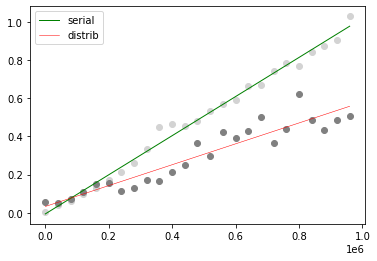

In [23]:
plt.scatter(X, Y_s, color="lightgray")
plt.scatter(X, Y_d, color="gray")

plt.plot(X, Y_s_pred, color="green", linewidth=1, label="serial")
plt.plot(X, Y_d_pred, color="red", linewidth=0.5, label="distrib")

plt.legend()
plt.show()

The distributed processing shows less time required for the tasks in aggregate.
Let's calculate how much speedup, based on a ratio of the *slope* values for the two fitted regressions:

In [24]:
m = (Y_s_pred / Y_d_pred)
m

array([[-0.1970066 ],
       [ 0.63574315],
       [ 0.99069504],
       [ 1.18739054],
       [ 1.31237503],
       [ 1.39881845],
       [ 1.46216651],
       [ 1.51058418],
       [ 1.54879337],
       [ 1.57971476],
       [ 1.60525185],
       [ 1.62669836],
       [ 1.64496426],
       [ 1.66070825],
       [ 1.67441889],
       [ 1.6864662 ],
       [ 1.69713556],
       [ 1.70665059],
       [ 1.715189  ],
       [ 1.72289382],
       [ 1.72988144],
       [ 1.73624755],
       [ 1.74207153],
       [ 1.74741981],
       [ 1.75234838]])

Now we can plot these ratios, and take their median value:

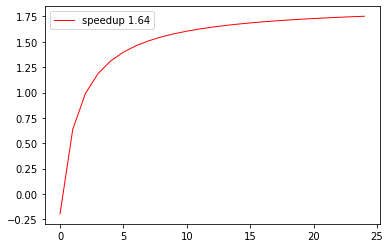

In [25]:
plt.plot(m, color="red", linewidth=1, label="speedup {:.2f}".format(np.median(m)))
plt.legend()
plt.show()

Depending on the number of available CPUs, you should see an asymptotically linear increase in performance.

## Exercise

Try running the `Sim` simulation again in its parallelized mode, with a much larger number of samples.
While that's running, check the Ray dashboard to see how processing for the *remote tasks* gets distributed across the available CPUs.

Finally, shutdown Ray

In [26]:
ray.shutdown()